# Measure the Difference between Preprint-Published similarity and Published Articles

This notebook measures the time delay that results from the peer review process. Two plots are generated: one that depict the average publication time delay as changes are demanded from the peer review process and the other that depicts the added time delay as preprints have to undergo multiple versions to be published.

This notebook has a reviewer request section that aims to answer questions raised by reviewers. Also graphs have been reduced to only use graphs that are in the paper for ease of readability.

In [1]:
from datetime import timedelta
import random
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from scipy.stats import linregress, spearmanr
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
import tqdm

from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format

import warnings

mpl.rcParams["figure.dpi"] = 250
warnings.filterwarnings("ignore")

# Load the Document Distances

In [2]:
published_date_distances = pd.read_csv(
    "output/preprint_published_distances.tsv", sep="\t"
)
for col in ["preprint_date", "published_date"]:
    published_date_distances[col] = pd.to_datetime(published_date_distances[col])
published_date_distances["time_to_published"] = pd.to_timedelta(
    published_date_distances["time_to_published"]
)
print(published_date_distances.shape)
published_date_distances.head()

(17527, 12)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published,doc_distances
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days,1.360377
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days,0.470905
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days,0.533702
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days,0.646077
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days,0.959715


In [3]:
published_date_distances["days_to_published"] = published_date_distances[
    "time_to_published"
].dt.days

In [4]:
remove_negative_time_to_published = True
if remove_negative_time_to_published:
    published_date_distances = published_date_distances[
        published_date_distances["days_to_published"] >= 0
    ]

# Construct Scatter Plot of Date vs Version Count

Preprints are delayed on an average of 51 days for each new version posted onto bioRxiv. This section regresses preprint's version counts against the time it takes to have a preprint published. A scatter and square bin plot are generated below.

In [5]:
# Get smoothed linear regression line
x = published_date_distances.version_count.values.tolist()

y = published_date_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.67308073983789, intercept=133.5346031692294, rvalue=0.30382607616433754, pvalue=0.0, stderr=1.2010600586705775, intercept_stderr=2.036013299017377)


In [6]:
x_line = np.array(
    [
        published_date_distances["version_count"].min(),
        published_date_distances["version_count"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

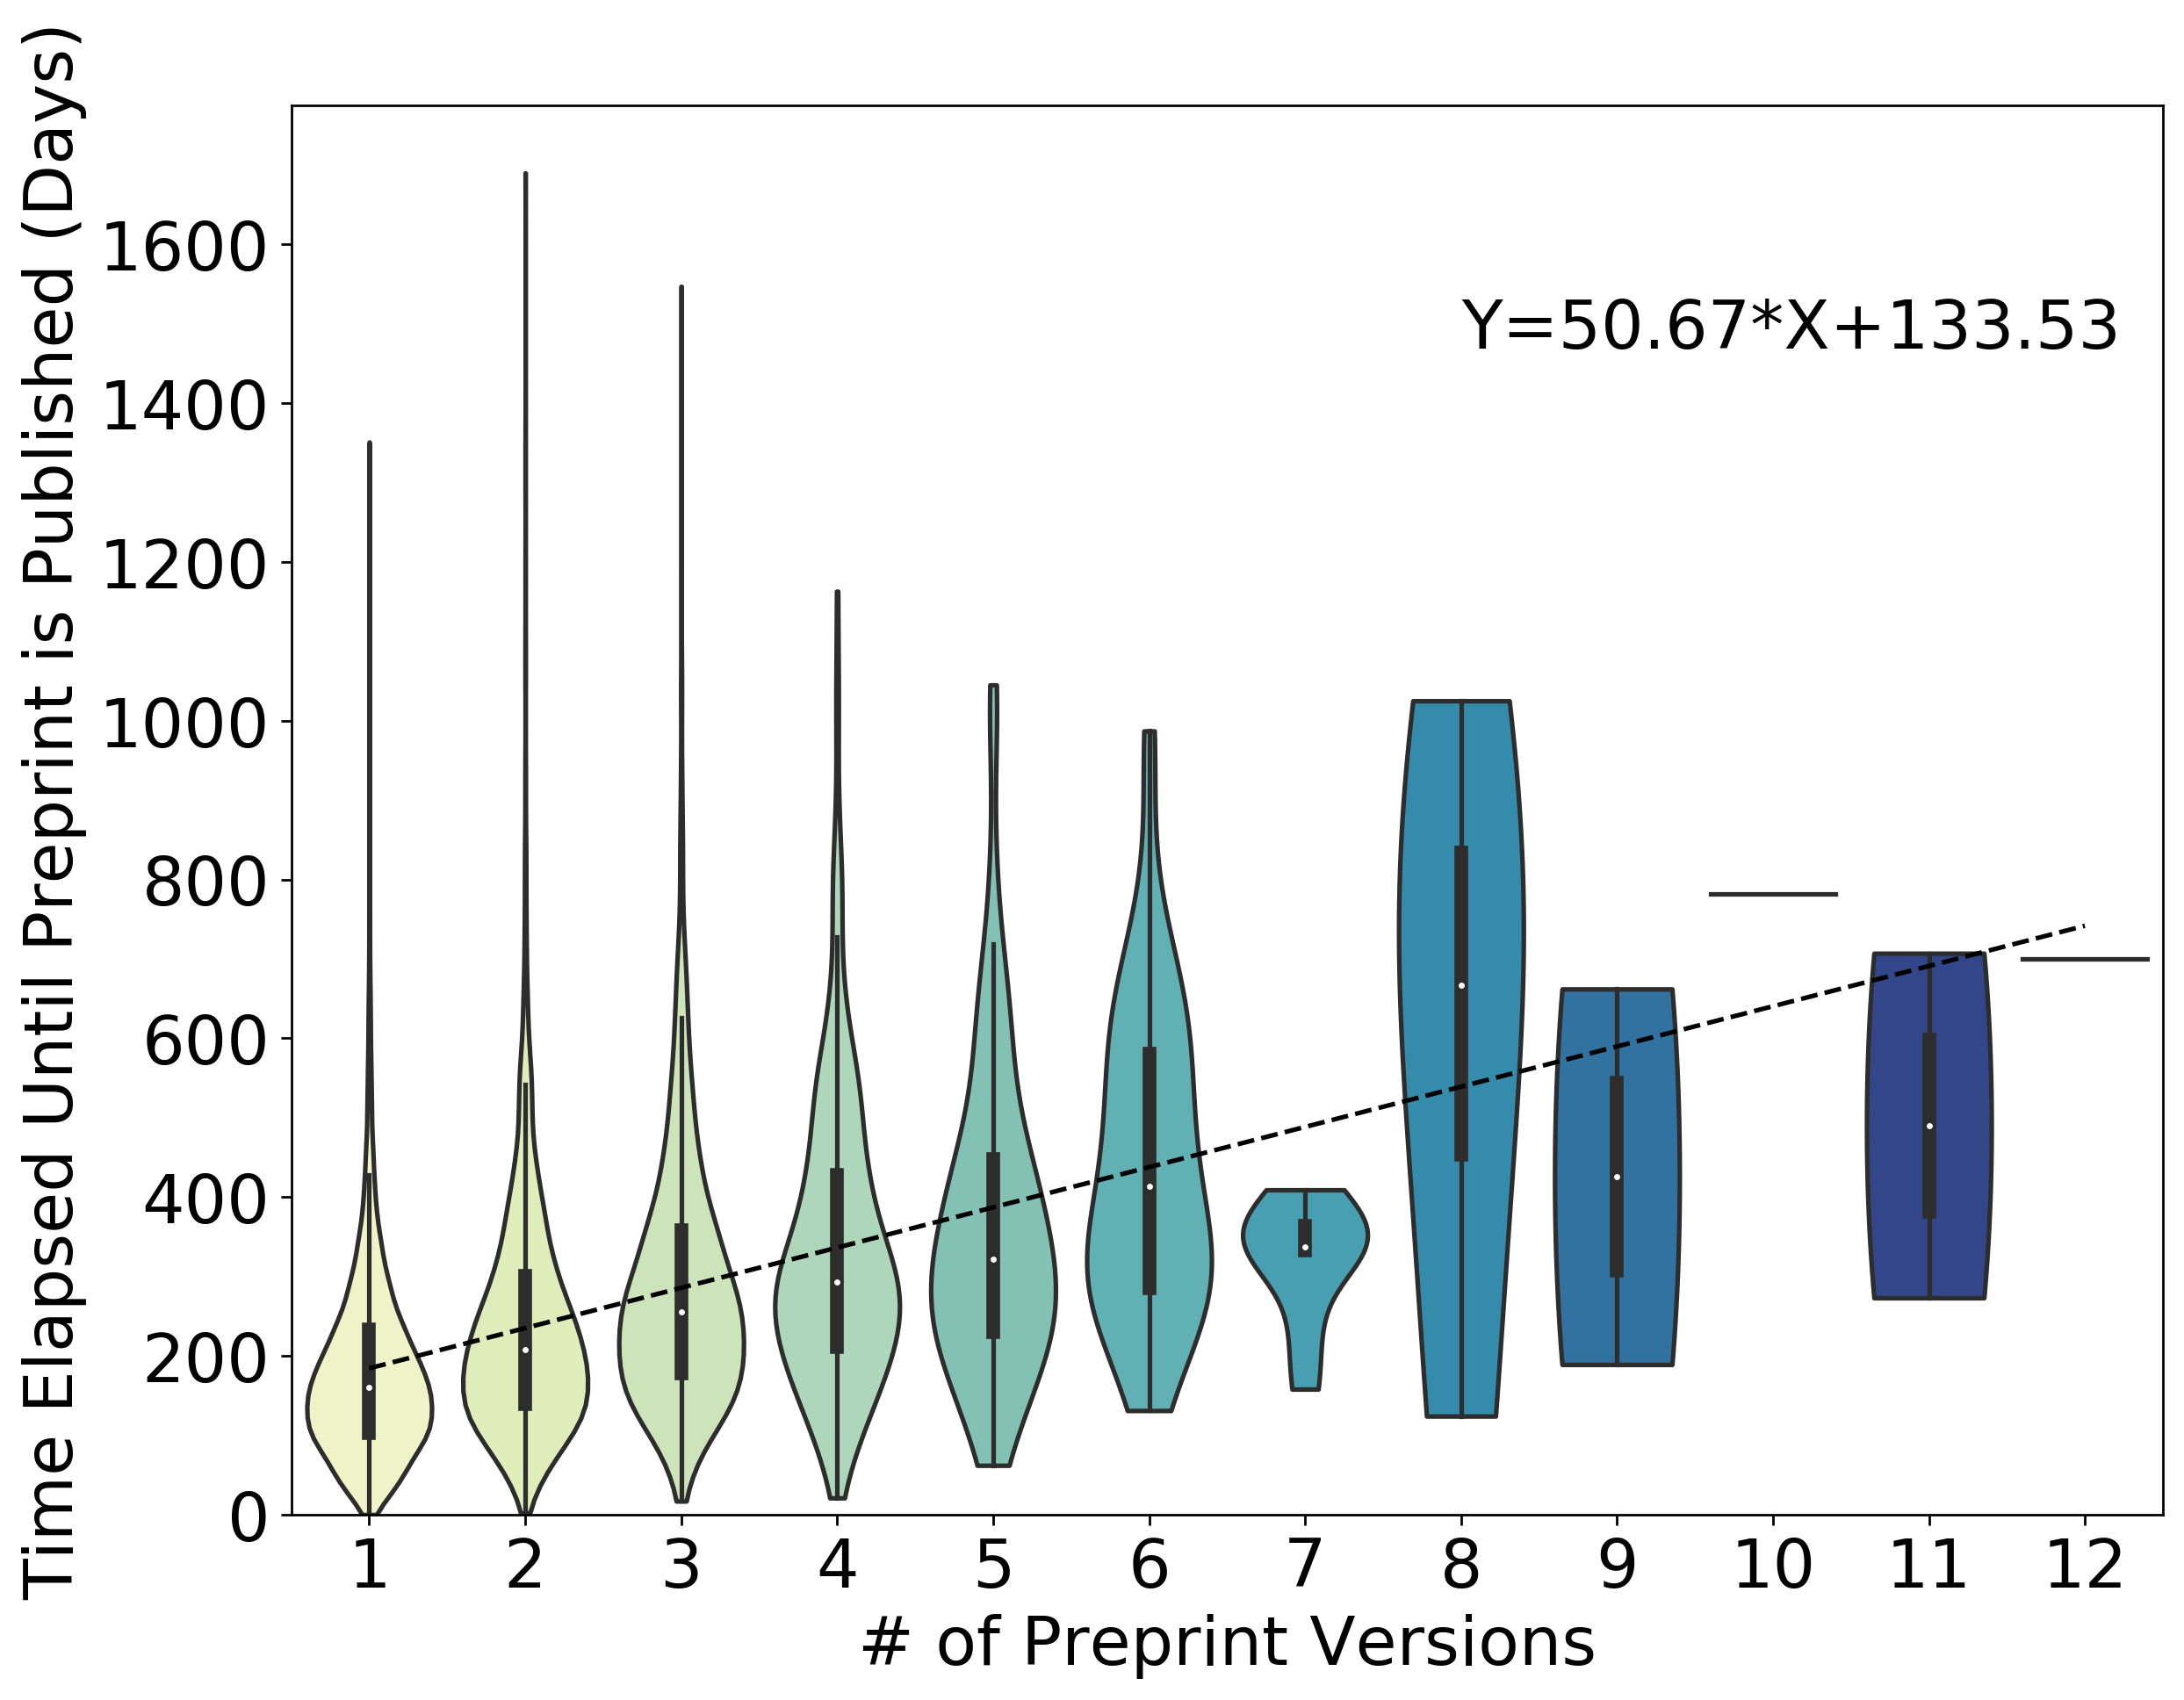

In [7]:
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 22})
g = sns.violinplot(
    x="version_count",
    y="days_to_published",
    data=published_date_distances,
    cut=0,
    scale="width",
    palette="YlGnBu",
)
_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (7, 1470))
_ = g.set_xlim(-0.5, 11.5)
_ = g.set_ylim(0, g.get_ylim()[1])
plt.savefig("output/version_count_vs_publication_time_violin.svg", dpi=500)
plt.savefig("output/version_count_vs_publication_time_violin.png", dpi=500)

# Construct Scatter Plot of Date vs Document Distances

Preprints are delayed on an average of 17 days as changes are demanded from the peer-review process. This section regresses a preprint's document distance against the time it takes to have a preprint published. A scatter and square bin plot are generated below.

In [8]:
# Get smoothed linear regression line
# Removed negative time here
x = published_date_distances.doc_distances.values.tolist()

y = published_date_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=43.20514193725474, intercept=168.91976409930672, rvalue=0.19907430135932783, pvalue=6.162481426506667e-156, stderr=1.6076190784412652, intercept_stderr=1.791207618456076)


In [9]:
x_line = np.array(
    [
        published_date_distances["doc_distances"].min(),
        published_date_distances["doc_distances"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

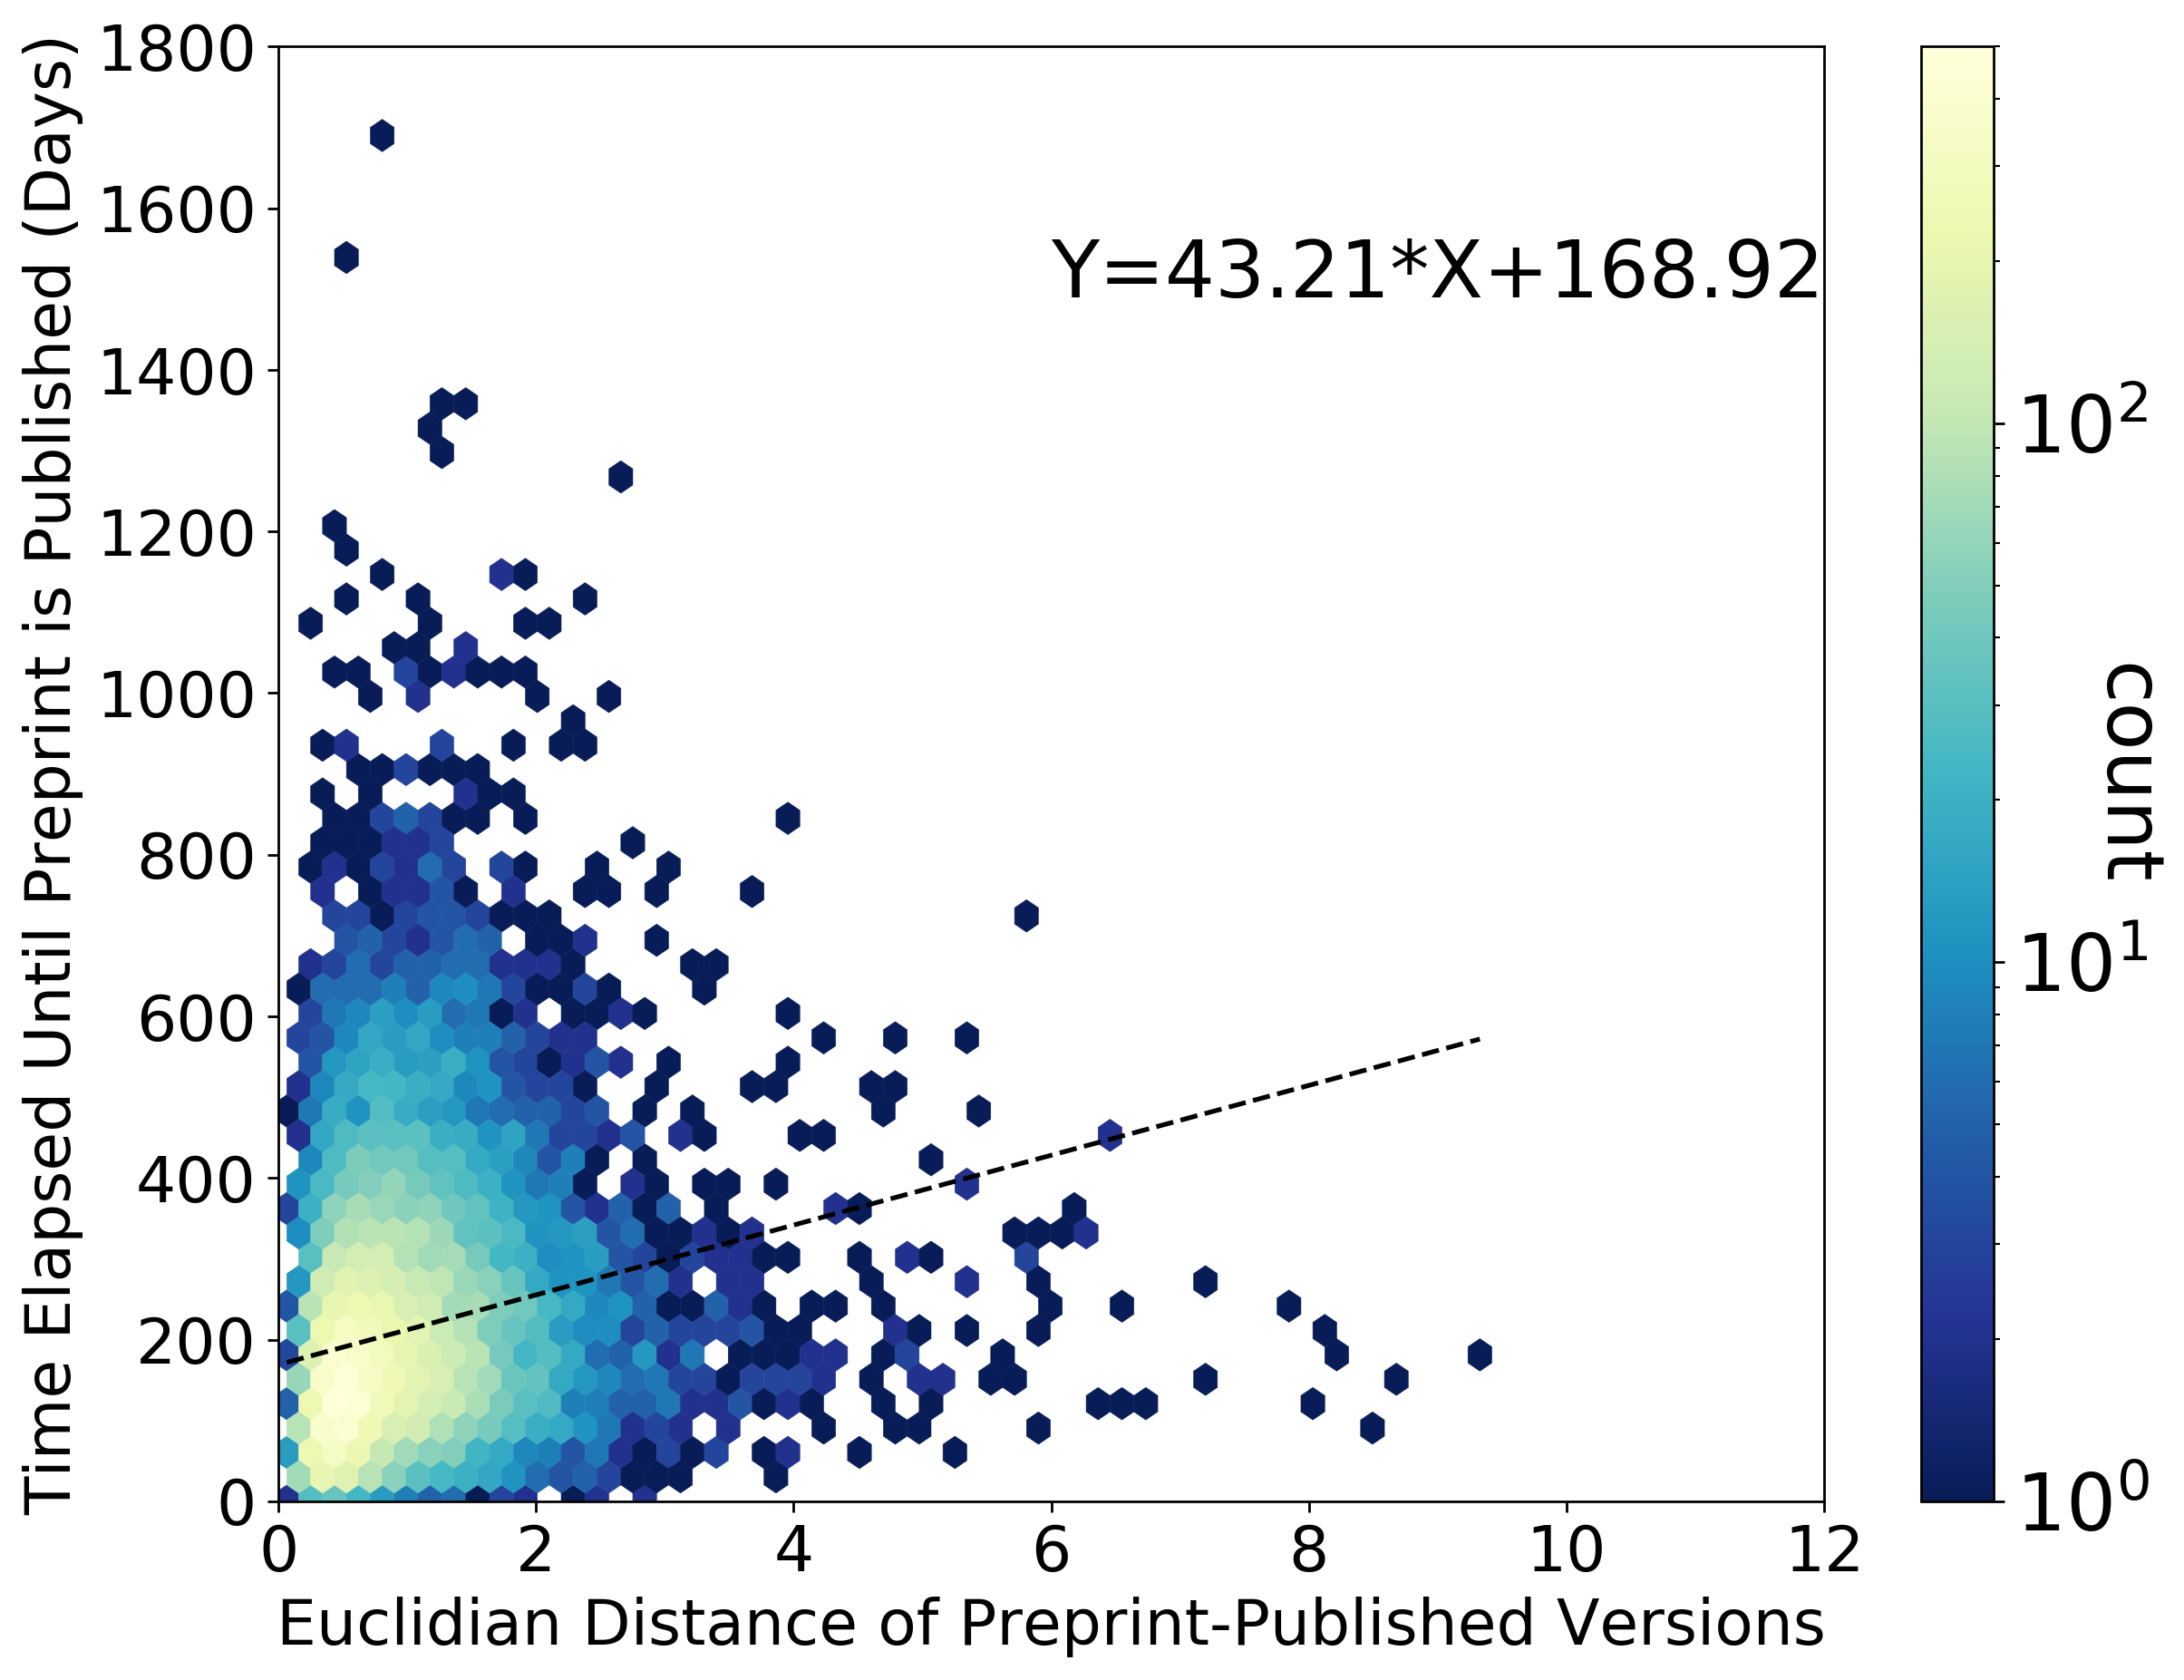

In [10]:
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 25})
ax = plt.hexbin(
    published_date_distances["doc_distances"],
    published_date_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
plt.xlim([0, 12])
plt.ylim([0, 1800])
ax = plt.gca()
ax.plot(x_line, y_line, "--k")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_size(20)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    (6, 1490),
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)
plt.savefig("output/article_distance_vs_publication_time_hex.svg", dpi=250)
plt.savefig("output/article_distance_vs_publication_time_hex.png", dpi=250)

# Reviewer Request

Based on manuscript review, a reviewer stated that majority of association comes from documents with high distances (figure above).
They asked if I would see the same results if I used spearman rank correlation.
They also asked if performing a log transformation would help with visualization.
The section below designed to answer both requests.

Review's message here:
```
The association given in Figure 4A seems to mainly stem from a few papers with large distances. Would an association be present when using the rank-based Spearman correlation instead of a linear regression? Would, for visualization, a logarithmic relationship describe the data better than a linear one?
```

One problem I'm having is that 4A is the life curve in my paper, but based on the literal text I think 4A is 4C.

In [11]:
# X and Y are defined above for document distance
# Stealing these variables here
spearmanr(x, y)

SpearmanrResult(correlation=0.2768879869442708, pvalue=1.4846261597721136e-305)

## Linear - Log Transformation

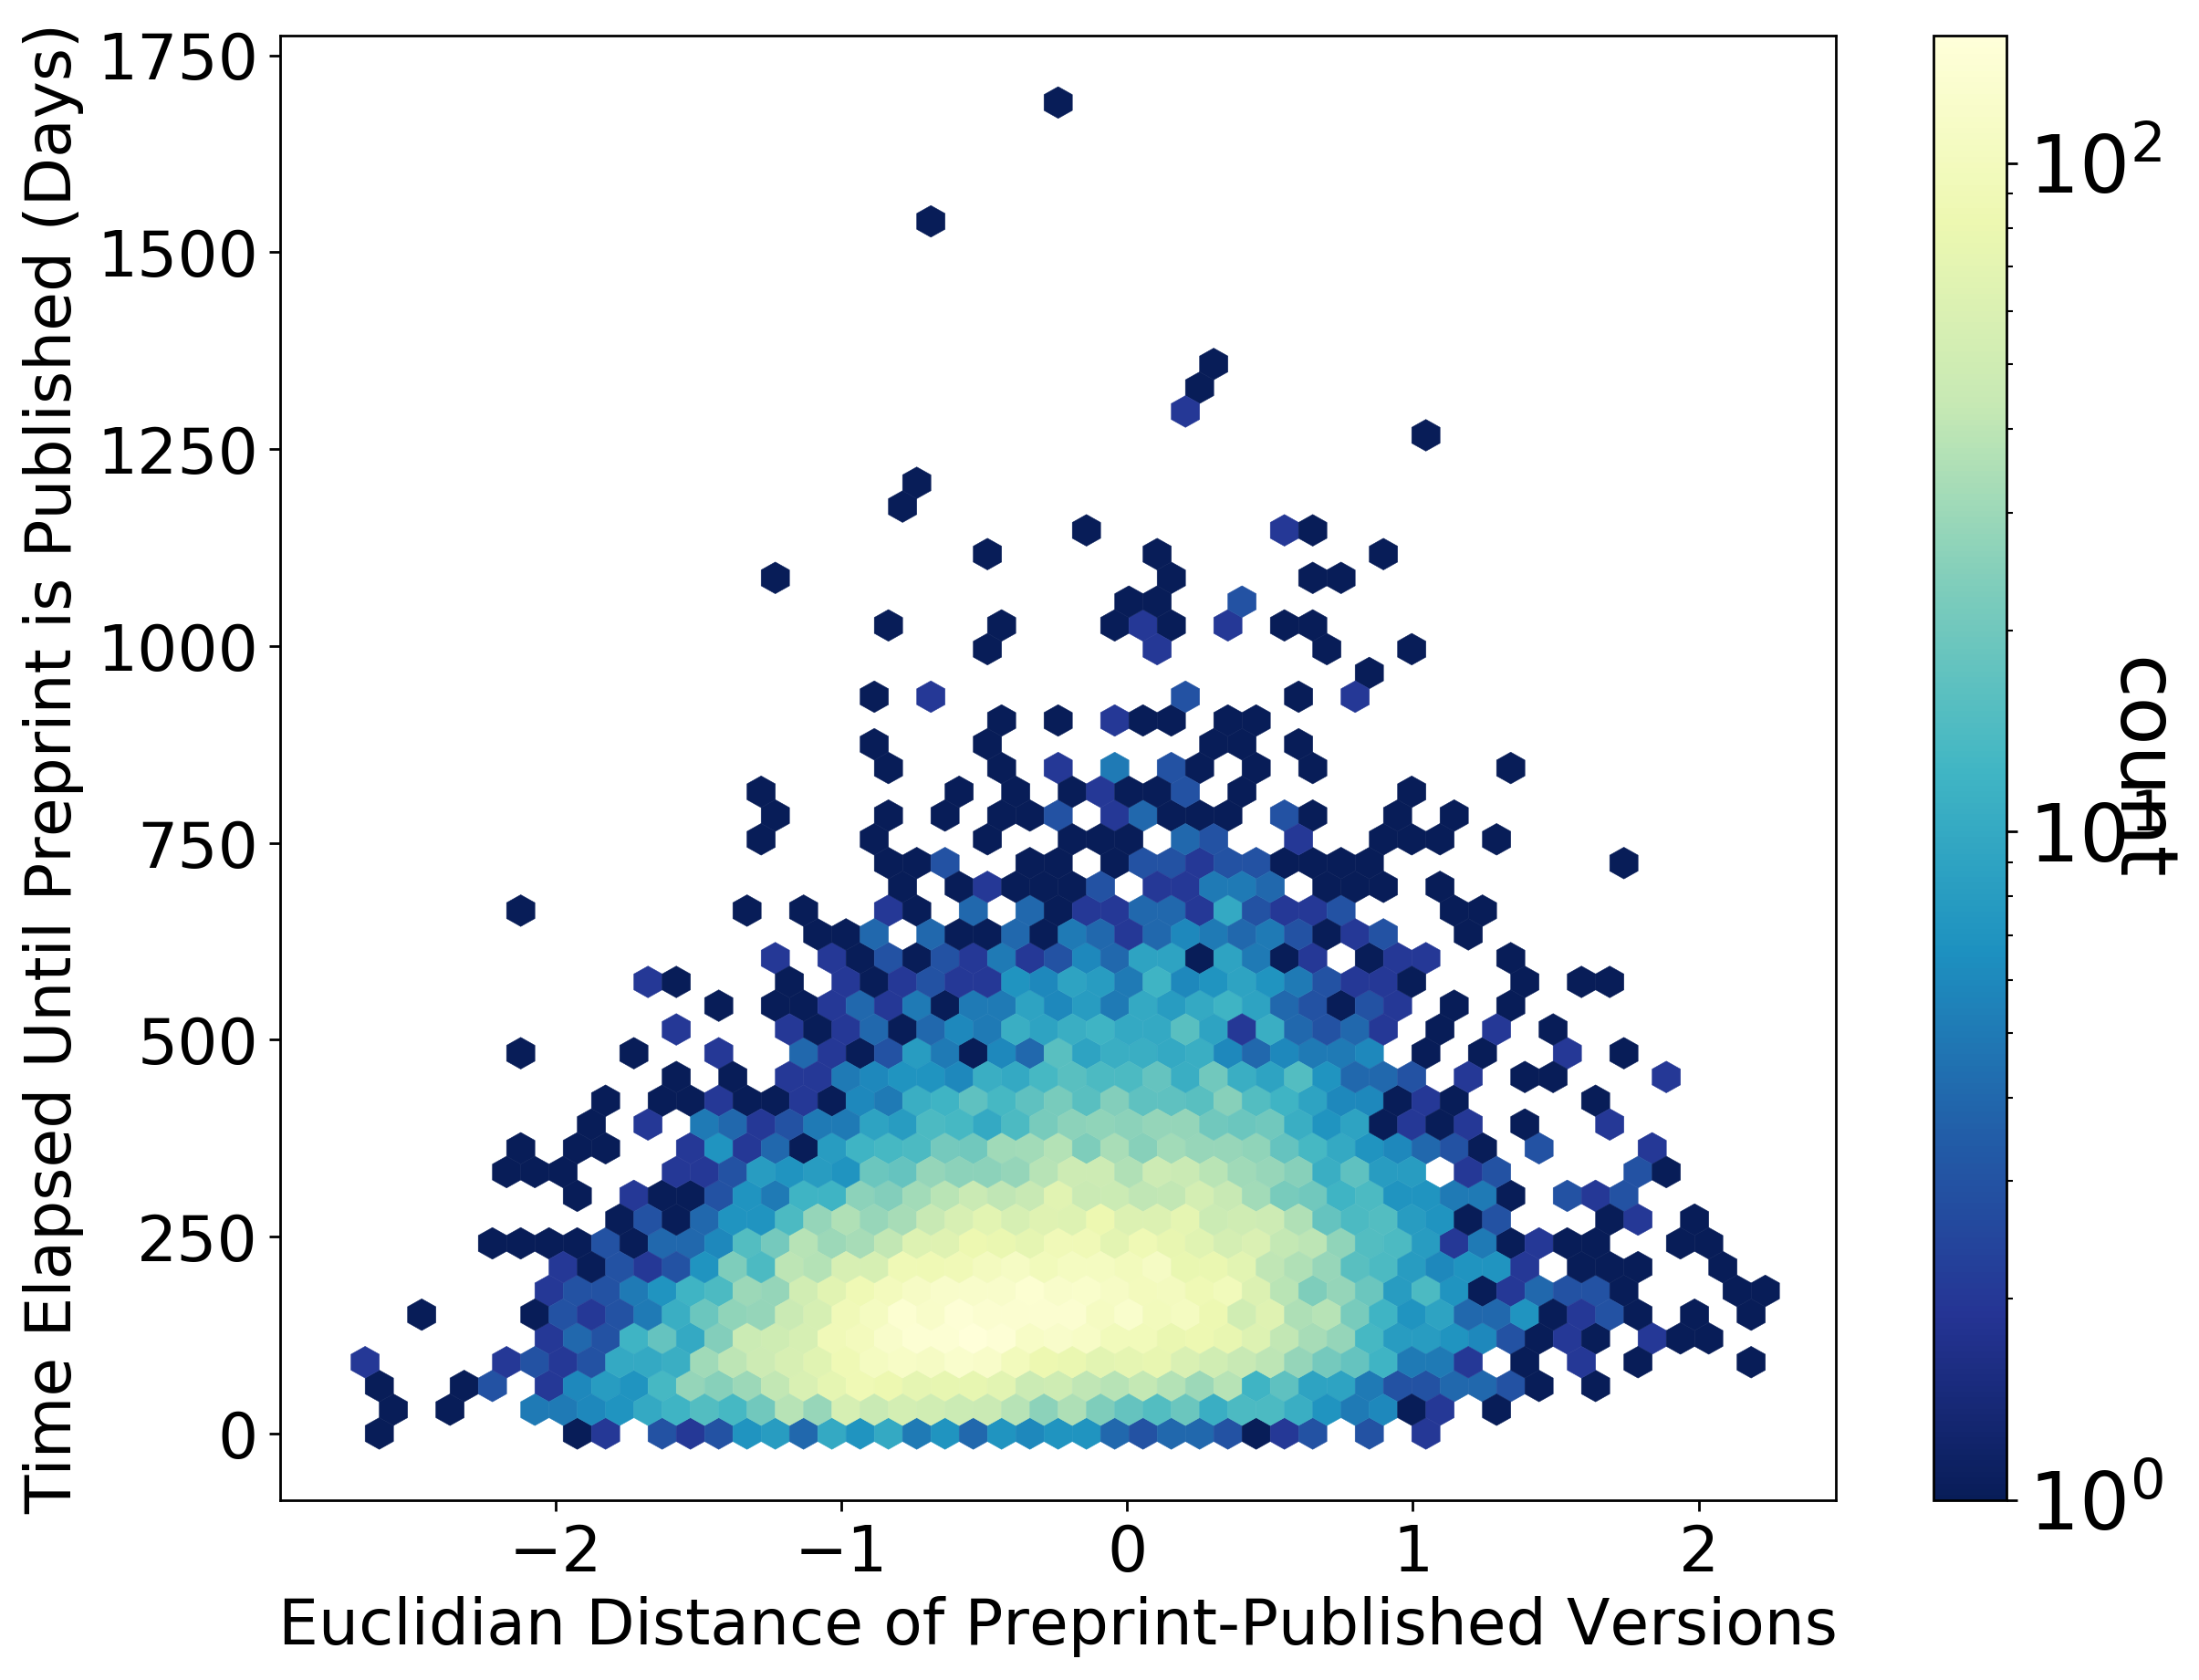

In [12]:
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 25})
ax = plt.hexbin(
    np.log(published_date_distances["doc_distances"] + 0.001),
    published_date_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
# plt.xlim([0, 12])
# plt.ylim([0, 1800])
ax = plt.gca()
# ax.plot(x_line, y_line, "--k")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_size(20)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# ax.annotate(
#    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
#    (6, 1490),
# )
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)

## Log-Log Transformation

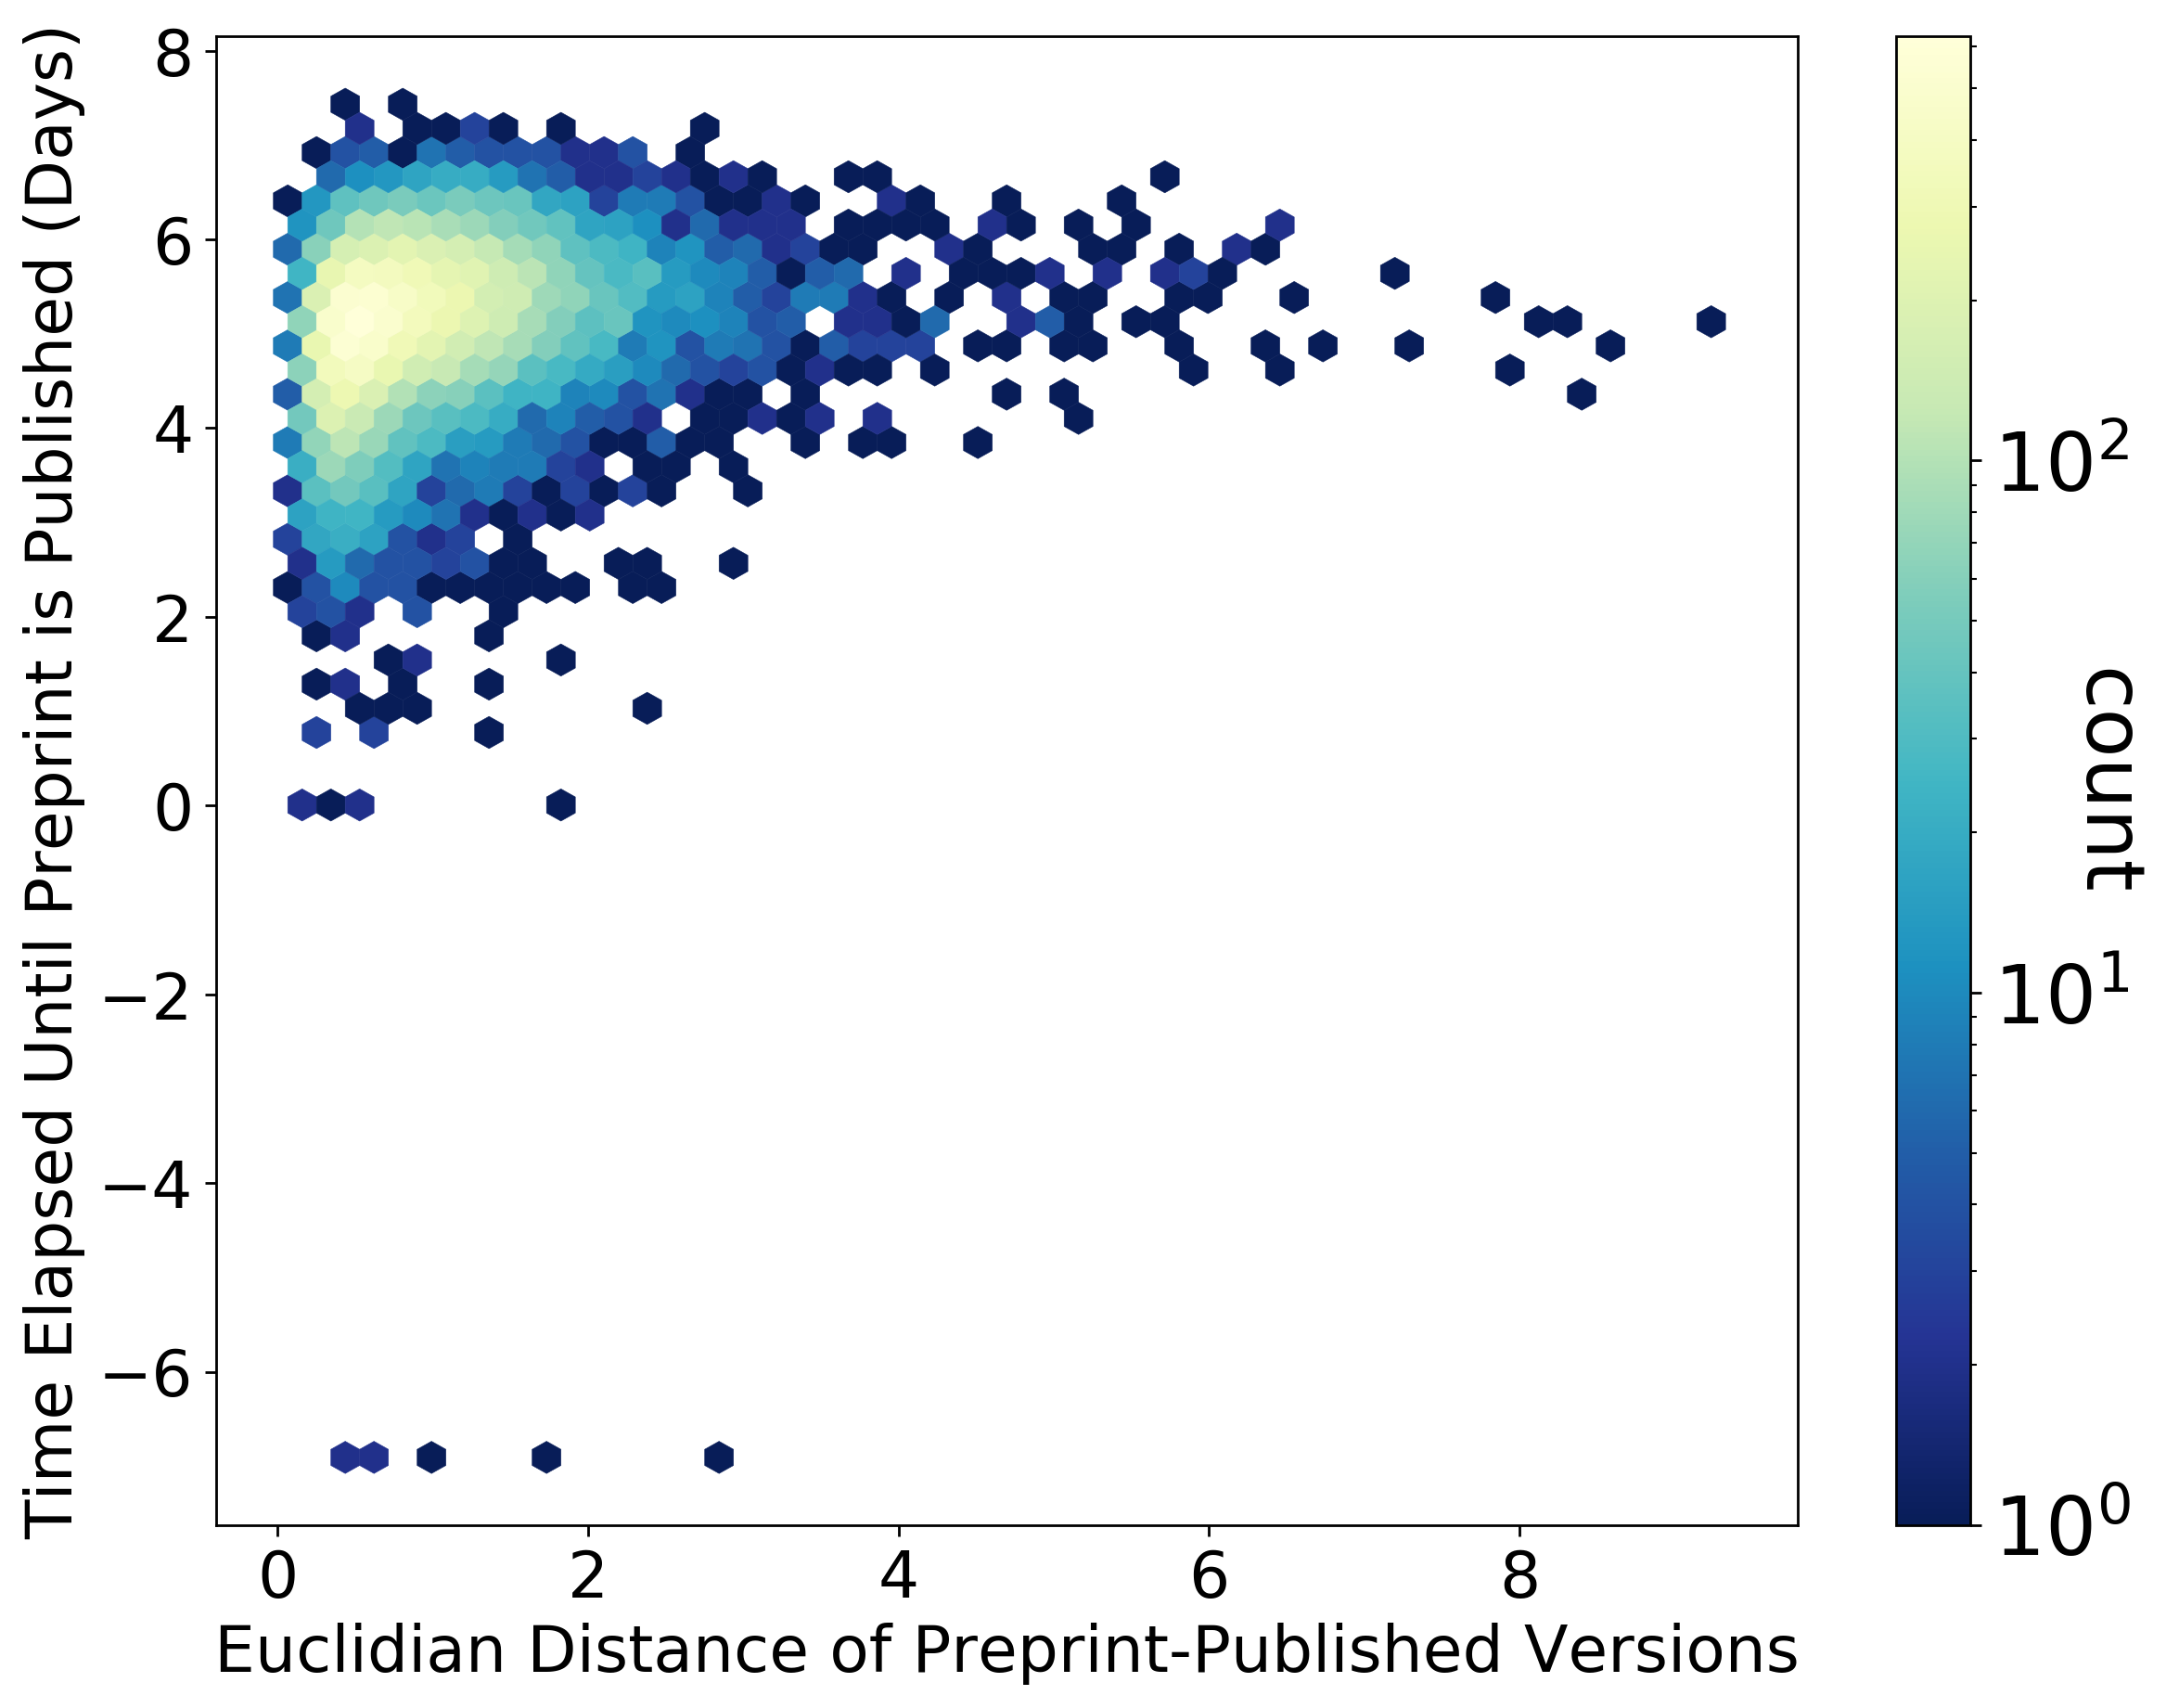

In [13]:
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 25})
ax = plt.hexbin(
    published_date_distances["doc_distances"],
    np.log(published_date_distances["days_to_published"] + 0.001),
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
# plt.xlim([0, 12])
# plt.ylim([0, 1800])
ax = plt.gca()
# ax.plot(x_line, y_line, "--k")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_size(20)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# ax.annotate(
#    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
#    (6, 1490),
# )
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)

## Log-Log Transformation

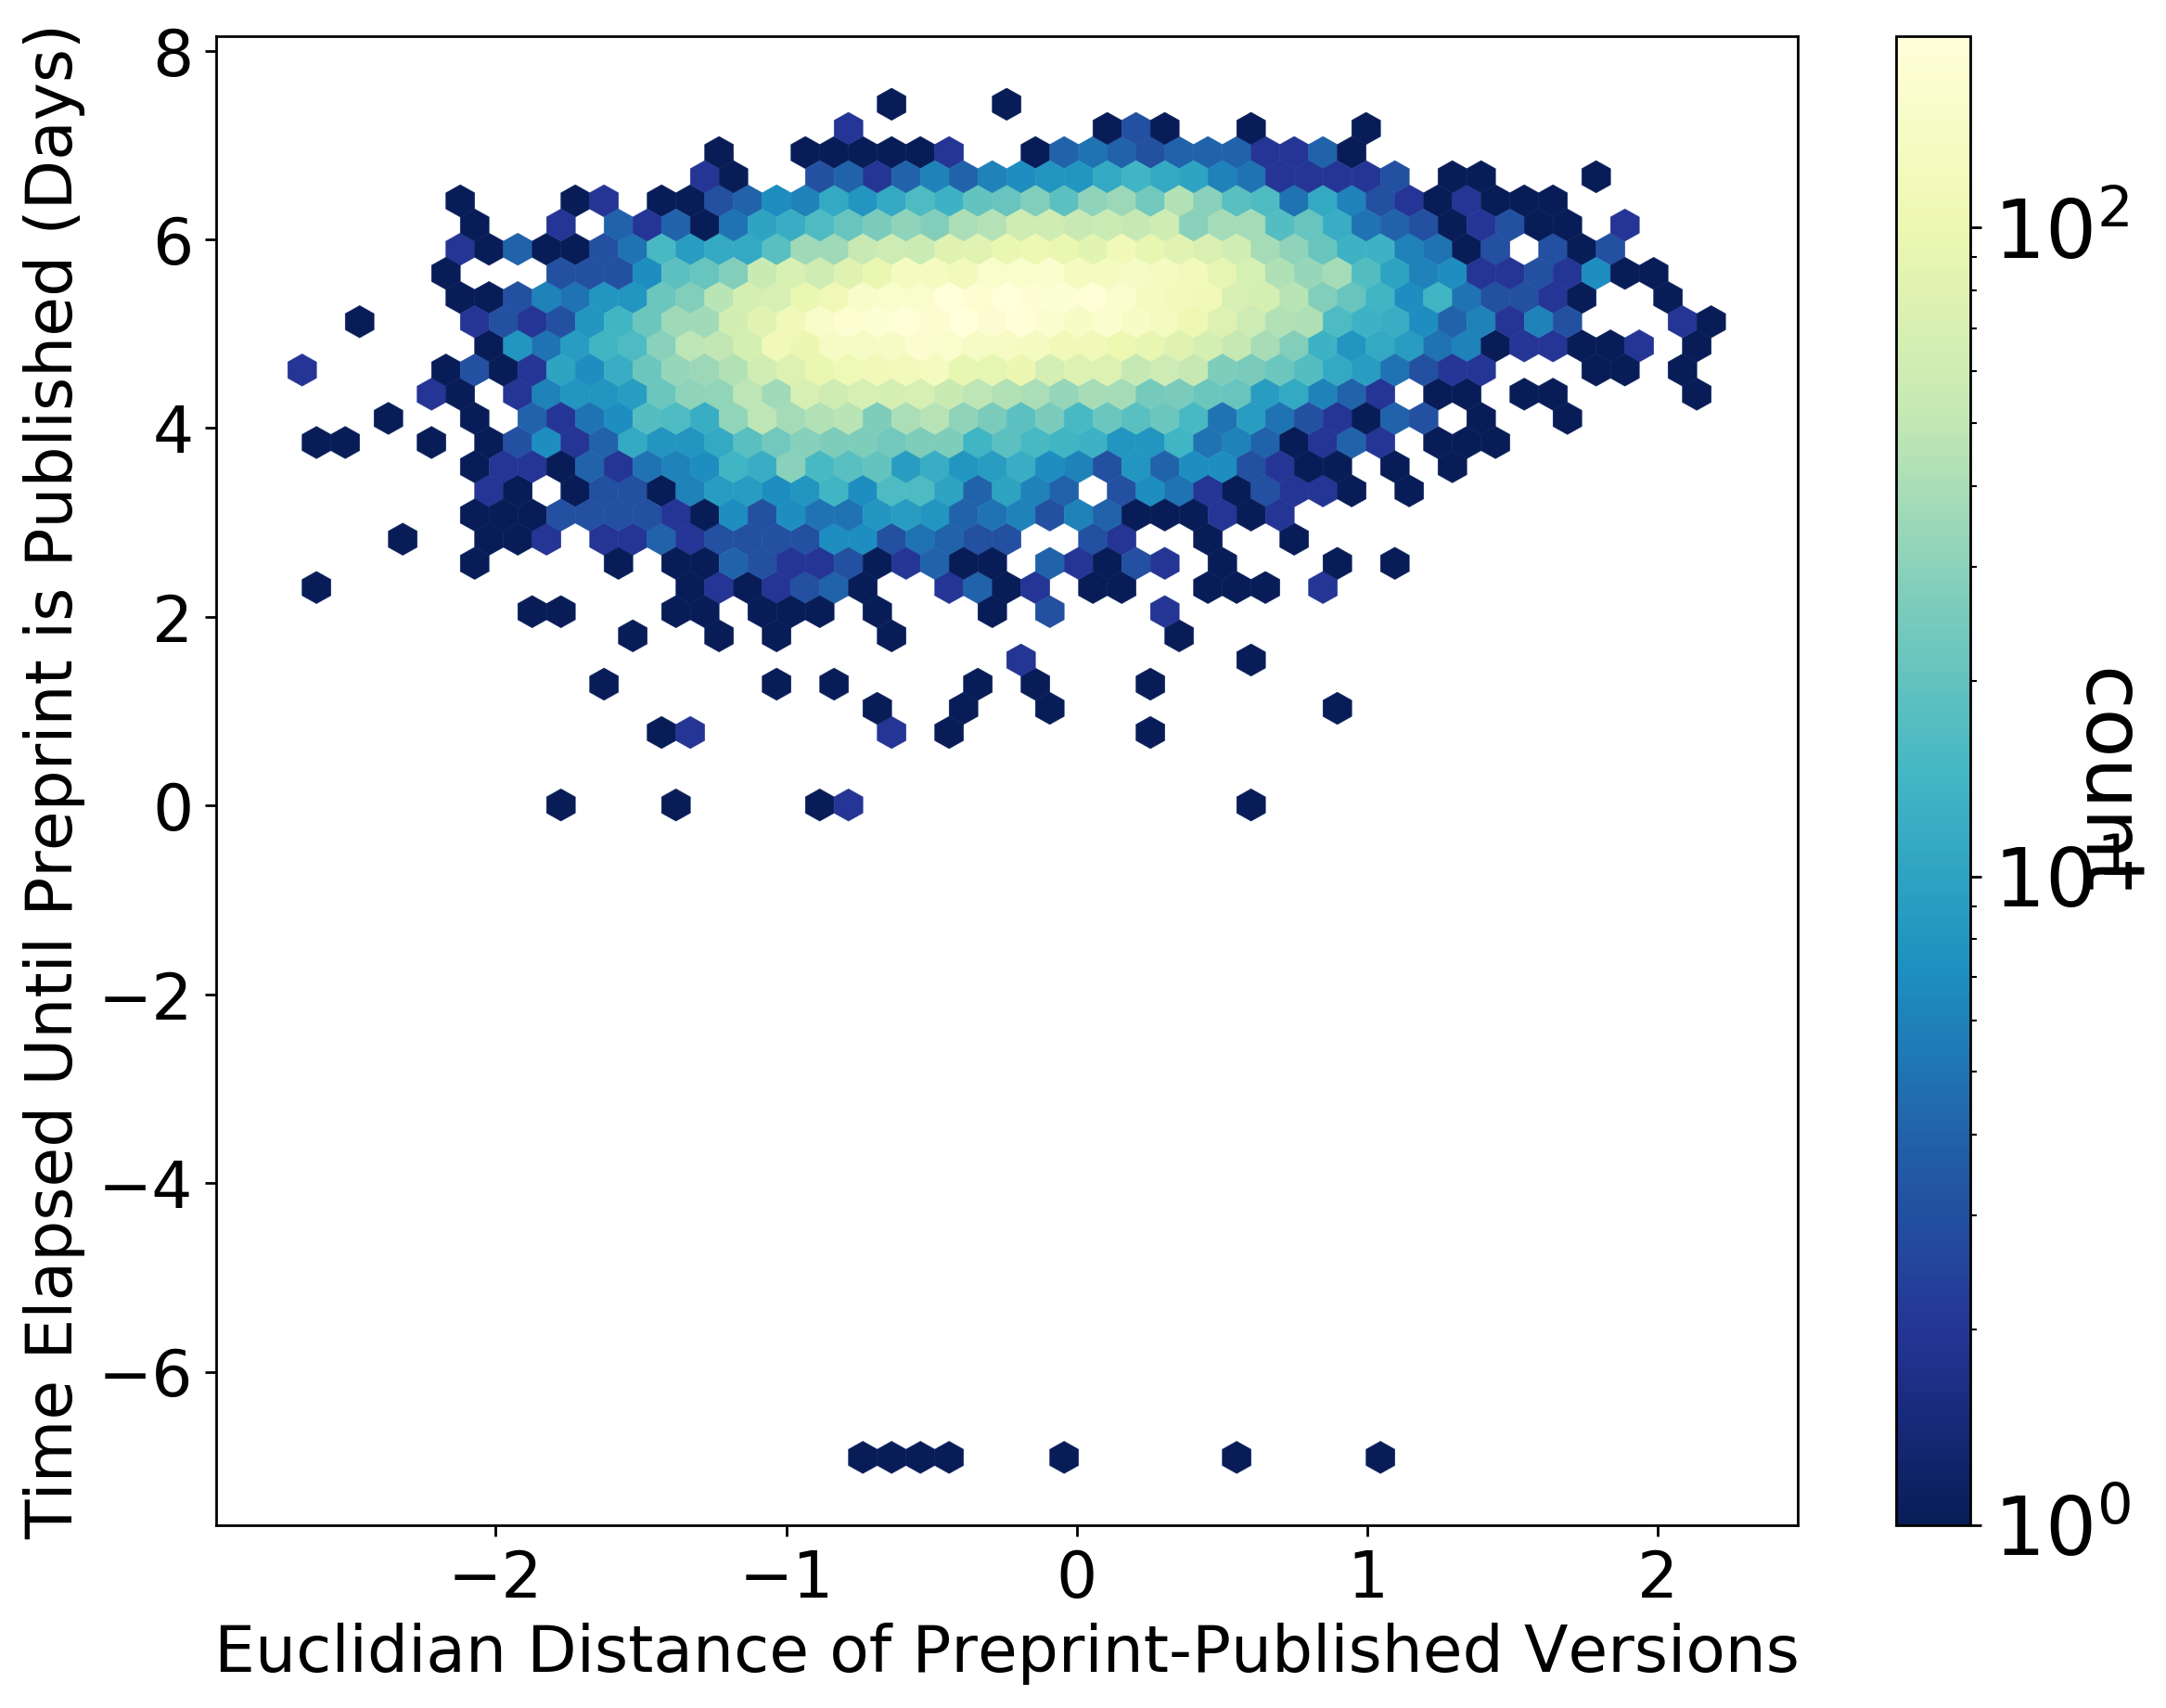

In [14]:
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 25})
ax = plt.hexbin(
    np.log(published_date_distances["doc_distances"] + 0.001),
    np.log(published_date_distances["days_to_published"] + 0.001),
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
# plt.xlim([0, 12])
# plt.ylim([0, 1800])
ax = plt.gca()
# ax.plot(x_line, y_line, "--k")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_size(20)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# ax.annotate(
#    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
#    (6, 1490),
# )
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)

Take Home Points:
1. Based on reviewer's request, spearman's correlation is provides a positive correlation between the two variables albeit small.
2. In terms of visualization take the log of documents highlights documents that take little to no time to be published. Don't believe that is desired for our analysis since the focus is on preprints that take longer to be published.